In [1]:
import networkx as nx
import dwave_networkx as dnx
import random
import matplotlib.pyplot as plt
import numpy as np

from uccgGenerator import tree_insertion, Graph
from plotNetwork import plotGraph, plotCoupling
from lpSolver import solve

In [2]:
def markov_chain_add_remove_edge(g_, k=3):
    g = Graph(g_)
    u, v = random.sample(g.nodes, 2)
    if (u, v) in g.edges:
        g.remove_edge(u, v)
        if not nx.is_connected(g) or not nx.is_chordal(g):
            g.add_edge(u, v)
        g.move = f"remove {(u, v)}"
    else:
#         if max([len(c) for c in nx.find_cliques(g)]) > k:
#             return g
        g.add_edge(u, v)
        if not nx.is_chordal(g):
            g.remove_edge(u, v)
        g.move = f"add {(u, v)}"
    return g

Suppose $G_1$ and $G_2$ are chordal graphs and $G_2=G_1-\{e\}$, where $e$ is an edge. Our goal is to sample a chordal chordal $G$ with probabilitiy proportional to $\lambda^{|G|}$, where $|G|$ is the number of edges. In order to make the Markov chain reversible, we need to have

In [3]:
from itertools import combinations

def get_children(g, k=3, lambd=1):
    children = []
    visited = set()
    total_prob = 0
    edges = list(combinations(g.nodes, 2))
    prob = 1/len(edges)
    for u, v in edges:
        cg = Graph(g)
        m = len(cg.edges)
        if (u, v) not in g.edges:
            cg.add_edge(u, v)
            if not nx.is_chordal(cg):
                continue
            cg.move = f"add {(u, v)}"
        else:
            cg.remove_edge(u, v)
            if not nx.is_connected(cg) or not nx.is_chordal(cg):
                continue
            cg.move = f"remove {(u, v)}"
#         if max([len(c) for c in nx.find_cliques(cg)]) > k:
#             continue
        if cg not in visited:
            cg.prob = prob * min(1, lambd**(len(cg.edges)-m))
            total_prob += cg.prob
            visited.add(cg)
            children.append(cg)
    cg = Graph(g)
    cg.prob = 1 - total_prob
    cg.move = "stay"
    children.append(cg)
    return children

In [4]:
def markov_chain_dist(g1, g2):
    visited = set()
    queue = [(g1, 0)]
    while queue:
        head, dist = queue.pop(0)
        if head == g2:
            return dist
        children = get_children(head)
        for child in children:
            if child not in visited:
                visited.add(child)
                queue.append((child, dist+1))
    return -1

In [17]:
g1 = tree_insertion(6, 10)
for _ in range(5):
    g1 = markov_chain_add_remove_edge(g1)
g2 = markov_chain_add_remove_edge(g1)

remove (2, 1)


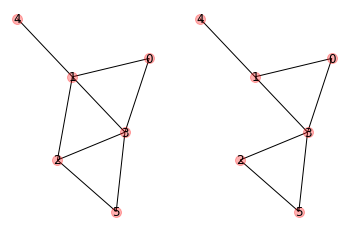

In [18]:
plt.figure()
plt.subplot(1,2,1)
plotGraph(g1)
plt.subplot(1,2,2)
plotGraph(g2, pos=nx.kamada_kawai_layout(g1))
print(f"{g2.move}")

In [20]:
lambd = 1
g1_children = get_children(g1, lambd=lambd)
g2_children = get_children(g2, lambd=lambd)
l1, l2 = len(g1_children), len(g2_children)
print(l1, l2)

11 13


In [21]:
dists = np.zeros((l1, l2))
count = 0
for i in range(l1):
    for j in range(l2):
        dists[i][j] = markov_chain_dist(g1_children[i], g2_children[j])
        count += 1
        if count % 10 == 0:
            print(count)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


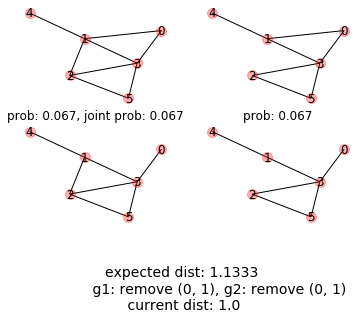

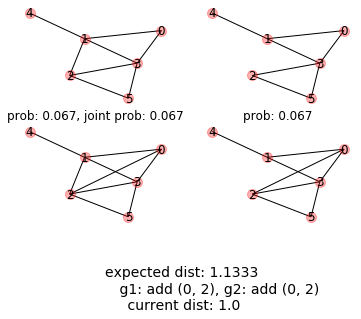

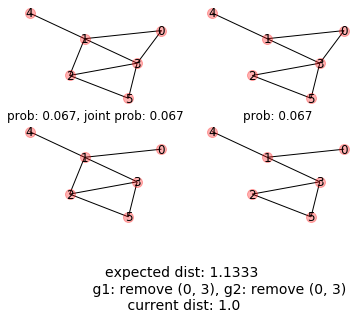

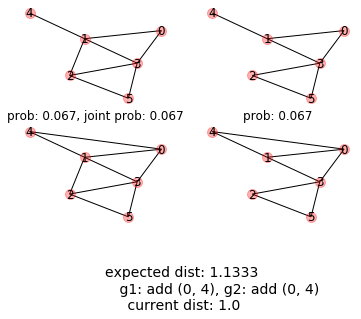

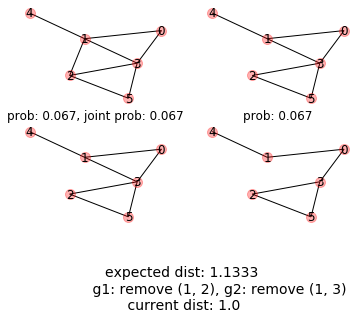

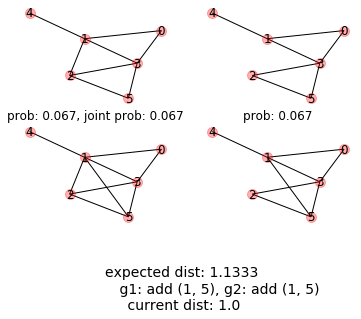

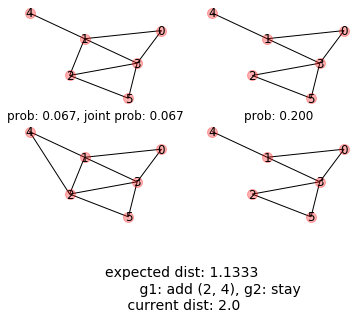

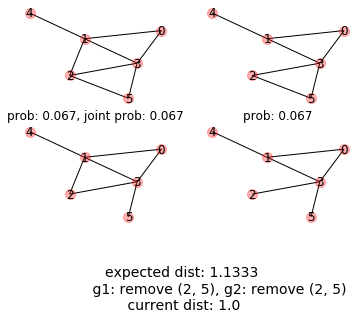

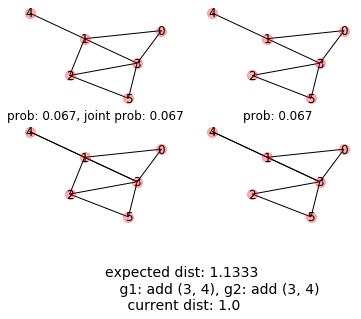

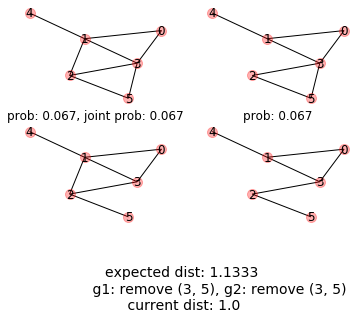

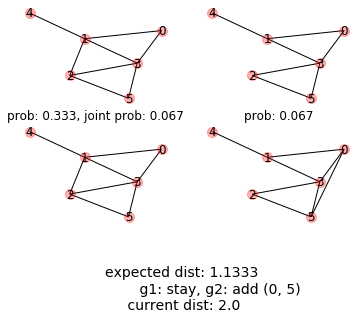

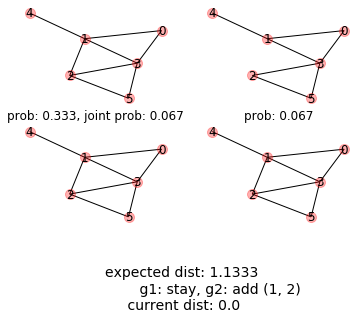

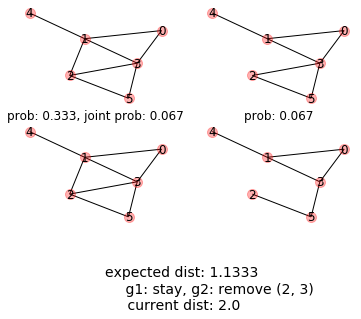

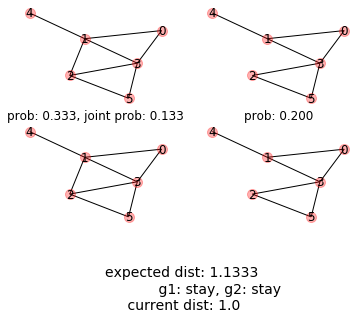

In [22]:
status, dist, joint_prob = solve(g1_children, g2_children, dists)
plotCoupling(g1, g2, g1_children, g2_children, dists, joint_prob, dist)
! rm *.png